In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("Resi/layoutlmv3-full-annotation-filtered")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 439
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 24
    })
})

In [5]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['B-Ersteller', 'B-Leitungsanlage', 'B-Dokumenttyp', 'B-Mast', 'B-Massstab', 'O'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None)}

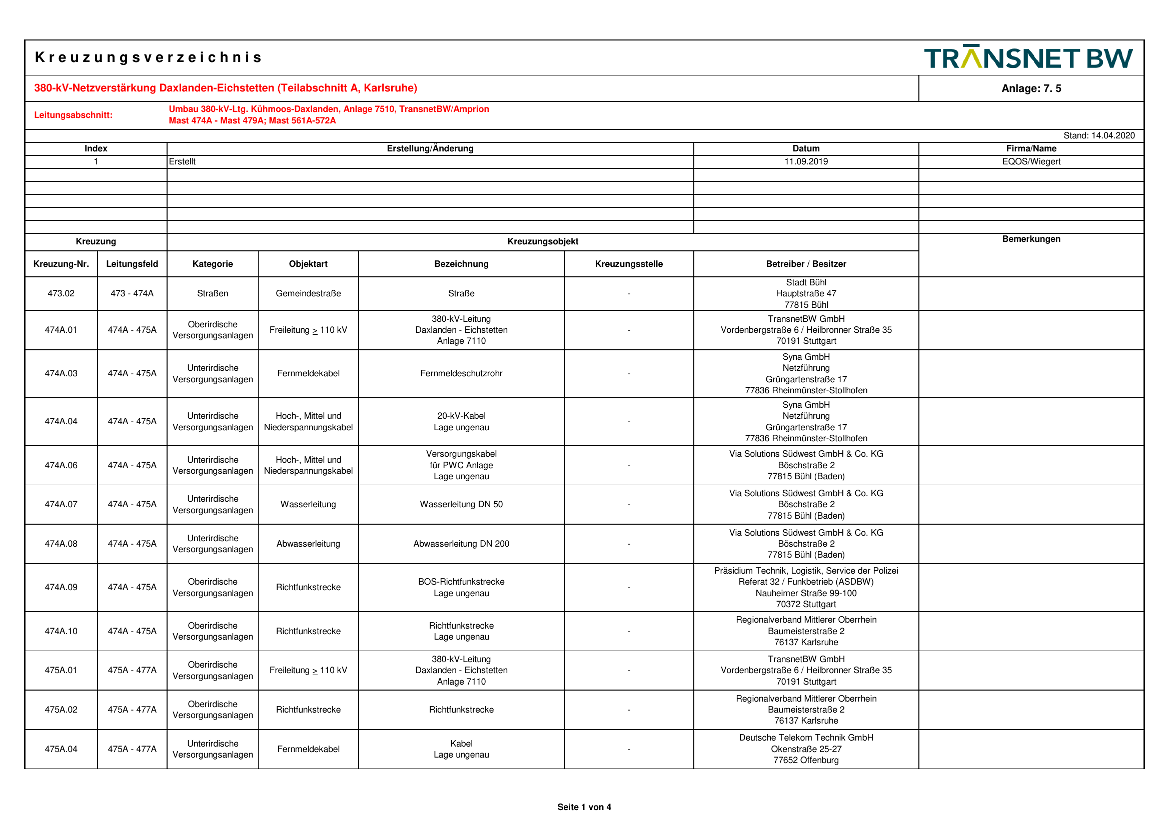

In [6]:
example = dataset["train"][0]
example["image"]

In [7]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['kreuzungsverzeichnis', 'transnet', 'bw', '380-kv-netaverstat', '{ung', 'daxlanden-eichstetten', '(teilabschnitt', 'a,', 'karlsruhe)', 'letungsabechat', '‘umbau', '386:6-lig,', 'kihmoos-devandan,', 'anaga', '751,', 'transnstgnwamprion', 'mast', '473a', '-', 'mast', 'a794;', 'mast', 's6uas72a', 'streieele', 'teezuga', '|', 'rosea', '|', 'vawgeie', '|', 'onan', 'a', '——', 'er', 'sathdtiainting', 'aalage', '7110', '70191', 'stuttgart', 'a74k.03,', 'atan-', '4750,', 'nein', 'femmeldekabel', 'fenmeldescnulzronr', 'lasreerat-1', '\\versorgurgsaniagen', '|', 'niederspannungskabel', '“', '©', 'flags', '17', '‘gurasaniaue', '77815', 'bil', '(bader', '=——', '77815', 'bil', '(bader', '=——', 'anlage', '7170', '70191', 'stuttgart', 'see', 'von']
[[30, 62, 223, 78], [789, 53, 923, 82], [929, 59, 968, 82], [29, 101, 107, 111], [117, 104, 132, 113], [136, 101, 234, 111], [237, 101, 307, 112], [300, 88, 309, 122], [311, 101, 356, 113], [29, 134, 93, 145], [141, 112, 169, 146], [172, 112, 212, 146], [2

In [8]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [9]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [10]:
print(label_list)

['B-Ersteller', 'B-Leitungsanlage', 'B-Dokumenttyp', 'B-Mast', 'B-Massstab', 'O']


In [11]:
print(id2label)

{0: 'B-Ersteller', 1: 'B-Leitungsanlage', 2: 'B-Dokumenttyp', 3: 'B-Mast', 4: 'B-Massstab', 5: 'O'}


In [12]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding
print("hi")

hi


In [13]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    batch_size=16,  # Set a smaller batch size, adjust according to your system's capabilities
    remove_columns=column_names,
    features=features
)

eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (119601594 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (119932722 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [14]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 439
})

In [15]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> kreuzungsverzeichnis transnet bw 380-kv-netaverstat {ung daxlanden-eichstetten (teilabschnitt a, karlsruhe) letungsabechat ‘umbau 386:6-lig, kihmoos-devandan, anaga 751, transnstgnwamprion mast 473a - mast a794; mast s6uas72a streieele teezuga | rosea | vawgeie | onan a —— er sathdtiainting aalage 7110 70191 stuttgart a74k.03, atan- 4750, nein femmeldekabel fenmeldescnulzronr lasreerat-1 \\versorgurgsaniagen | niederspannungskabel “ © flags 17 ‘gurasaniaue 77815 bil (bader =—— 77815 bil (bader =—— anlage 7170 70191 stuttgart see von</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [16]:
train_dataset.set_format("torch")

In [17]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [18]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 24
})

In [19]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> = gestange: 380/110-kv-4fach-leitung ad29-2016/04-11_|zchng.nr. 6128/1b-st —|mastteil: traverse 1 blatt 1(3) transnetbwhrip- __to...r0ce.. i anage ee pos. [stck. |benennung lange | material gewicht ober | __din/ artikel-nr. ‘bemerkungen. a kgim_| gesamt_| flache | _zeichnungs-nr. lieferant kg. m? stahikonstruktionen feuerverzinkt tor] 2 _|l 100x10 10575] __s355j2 15,00] 317,25] 8,25] 10: il 10x10 10575] _ s355u; 15,00] 317,25] 8,25] 403 | _2_|l 120x12 712) __s355j2 21,60] 30,76] __0,67| fschweiten 404 [2 |b 120x12 664] s355j2 21,60] 28,68] _0,62| tos] 2_|c120x12 604] s355j2 21,60] 26,09] 0.57 [schweifsen toe] _2_|l 120x12 556] _s355j2 21,60] 24,02] _0,52| ischweien 107 |_4_|l60x5 2505] _s355j2 4.57 | 45,79] 2,33] 708] 4 _|l60x5 408] _ s355v; 4.57] 44,0 24 709] 4 _|l60x5 2216] $3552 4,57] 40,49] 2,06] tio] 4 _|l50x5 7980| $3552 3,77 29,86] 1,54] th] 4 _|c50x5 tet2| s355i2 37 27,32] 1,41 ti2|_4_|l50x5 7595] $3552, 3,77 24,05] 1,24 113] 4 _|l</s>'

In [20]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 k 2
re -100
uz -100
ung -100
s -100
ver -100
ze -100
ich -100
nis -100
 trans 0
net -100
 b 5
w -100
 380 5
- -100
k -100
v -100
- -100
net -100
aver -100
stat -100
 { 5
ung -100
 d 1
ax -100
land -100
en -100
- -100
e -100
ich -100
st -100
et -100
ten -100
 ( 5
te -100
il -100
abs -100
chn -100
itt -100
 a 5
, -100
 k 5
arl -100
s -100
ru -100
he -100
) -100
 let 5
ung -100
s -100
ab -100
ech -100
at -100
 � 1
� 1
umb -100
au -100
 386 1
: -100
6 -100
- -100
lig -100
, -100
 k 5
ih -100
mo -100
os -100
- -100
dev -100
andan -100
, -100
 an 5
aga -100
 7 5
51 -100
, -100
 trans 5
n -100
st -100
gn -100
w -100
amp -100
r -100
ion -100
 mast 3
 4 3
73 -100
a -100
 - 3
 mast 3
 a 3
794 -100
; -100
 mast 3
 s 5
6 -100
u -100
as -100
72 -100
a -100
 stre 5
ie -100
ele -100
 te 5
ez -100
uga -100
 | 5
 rose 5
a -100
 | 5
 v 5
aw -100
ge -100
ie -100
 | 5
 on 5
an -100
 a 5
 — 5
— -100
 er 5
 s 5
ath -100
d -100
ti -100
ain -100
ting -100
 a 5
al -100
age -100
 71 1
10 -100
 701 5
9

In [21]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-21-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [22]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [23]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
pip install accelerate -U

In [25]:
# import accelerate
# print(accelerate.__version__)

In [26]:
# pip list

In [27]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# pip install transformers[torch]

In [29]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [30]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.169552,1.000000,0.068323,0.127907,0.965847
200,No log,0.121413,0.822785,0.403727,0.541667,0.975865
300,No log,0.101204,0.754098,0.571429,0.650177,0.978142
400,No log,0.089797,0.793893,0.645963,0.712329,0.981557
500,0.157400,0.075326,0.771242,0.732919,0.751592,0.982923
600,0.157400,0.067463,0.796053,0.751553,0.773163,0.984290
700,0.157400,0.083079,0.693548,0.801242,0.743516,0.980191


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.169552,1.000000,0.068323,0.127907,0.965847
200,No log,0.121413,0.822785,0.403727,0.541667,0.975865
300,No log,0.101204,0.754098,0.571429,0.650177,0.978142
400,No log,0.089797,0.793893,0.645963,0.712329,0.981557
500,0.157400,0.075326,0.771242,0.732919,0.751592,0.982923
600,0.157400,0.067463,0.796053,0.751553,0.773163,0.984290
700,0.157400,0.083079,0.693548,0.801242,0.743516,0.980191
800,0.157400,0.066332,0.835616,0.757764,0.794788,0.985883
900,0.157400,0.070476,0.779141,0.788820,0.783951,0.984290
1000,0.061800,0.068319,0.790123,0.795031,0.792570,0.984973


TrainOutput(global_step=1000, training_loss=0.10955952453613281, metrics={'train_runtime': 723.6144, 'train_samples_per_second': 2.764, 'train_steps_per_second': 1.382, 'total_flos': 526151549804544.0, 'train_loss': 0.10955952453613281, 'epoch': 4.545454545454545})

In [31]:
repo_name = "Resi/layoutlmv3-multilabel-v2-colab"

# here we push the processor and model to the hub
# note that you can add `private=True` in case you're using the private hub
# which makes sure the model is only shared with your colleagues
processor.push_to_hub(repo_name)
model.push_to_hub(repo_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Resi/layoutlmv3-multilabel-v2-colab/commit/0a180a4e8d9d624aeab834ee481cfbfef8e75ec4', commit_message='Upload LayoutLMv3ForTokenClassification', commit_description='', oid='0a180a4e8d9d624aeab834ee481cfbfef8e75ec4', pr_url=None, pr_revision=None, pr_num=None)

In [32]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.06831932067871094,
 'eval_precision': 0.7901234567901234,
 'eval_recall': 0.7950310559006211,
 'eval_f1': 0.7925696594427244,
 'eval_accuracy': 0.9849726775956285,
 'eval_runtime': 2.7078,
 'eval_samples_per_second': 8.863,
 'eval_steps_per_second': 4.432,
 'epoch': 4.545454545454545}

In [33]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

In [94]:
example = dataset["test"][13]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'])


In [95]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 277])
attention_mask torch.Size([1, 277])
bbox torch.Size([1, 277, 4])
labels torch.Size([1, 277])
pixel_values torch.Size([1, 3, 224, 224])


In [96]:
with torch.no_grad():
  outputs = model(**encoding)

In [97]:
logits = outputs.logits
logits.shape

torch.Size([1, 277, 6])

In [98]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 1, 1, 1, 1, 5, 5, 5, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 5, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 3, 3, 5, 5, 3, 1, 1, 3, 3, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [99]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 5, 5, -100, -100, 5, -100, 5, -100, -100, -100, 5, -100, -100, -100, 5, -100, -100, -100, -100, -100, 5, -100, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, 0, -100, 5, -100, 5, -100, -100, -100, -100, -100, 5, 5, 5, 5, -100, -100, 5, 5, 5, 5, 5, -100, 5, -100, 5, -100, -100, -100, -100, -100, 5, 5, -100, -100, -100, -100, 5, -100, 5, -100, -100, -100, 5, -100, -100, -100, -100, -100, -100, -100, 5, -100, -100, 1, -100, -100, -100, -100, 5, 5, 5, 1, -100, -100, -100, -100, 5, 1, -100, -100, -100, 5, 5, 2, -100, -100, 5, 5, 5, -100, 5, -100, 5, 5, 5, 5, -100, 5, -100, 5, 5, -100, 5, -100, -100, 5, 3, 3, 5, 5, -100, 5, -100, -100, 5, 5, 5, 5, -100, -100, -100, -100, -100, 5, -100, -100, -100, 5, -100, -100, -100, 1, -100, -100, -100, -100, 1, -100, -100, -100, -100, 5, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 5, 5, 5, 5, -100, 5, 5, 5, 5, -100, 5, 5, 5, 5, -100, 5, 5, 5, 5, -100, -100, 5, -100, -100, 5, -100, -100, 1, -100, -100, -100, -100, 5, -100, 5, 

In [100]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

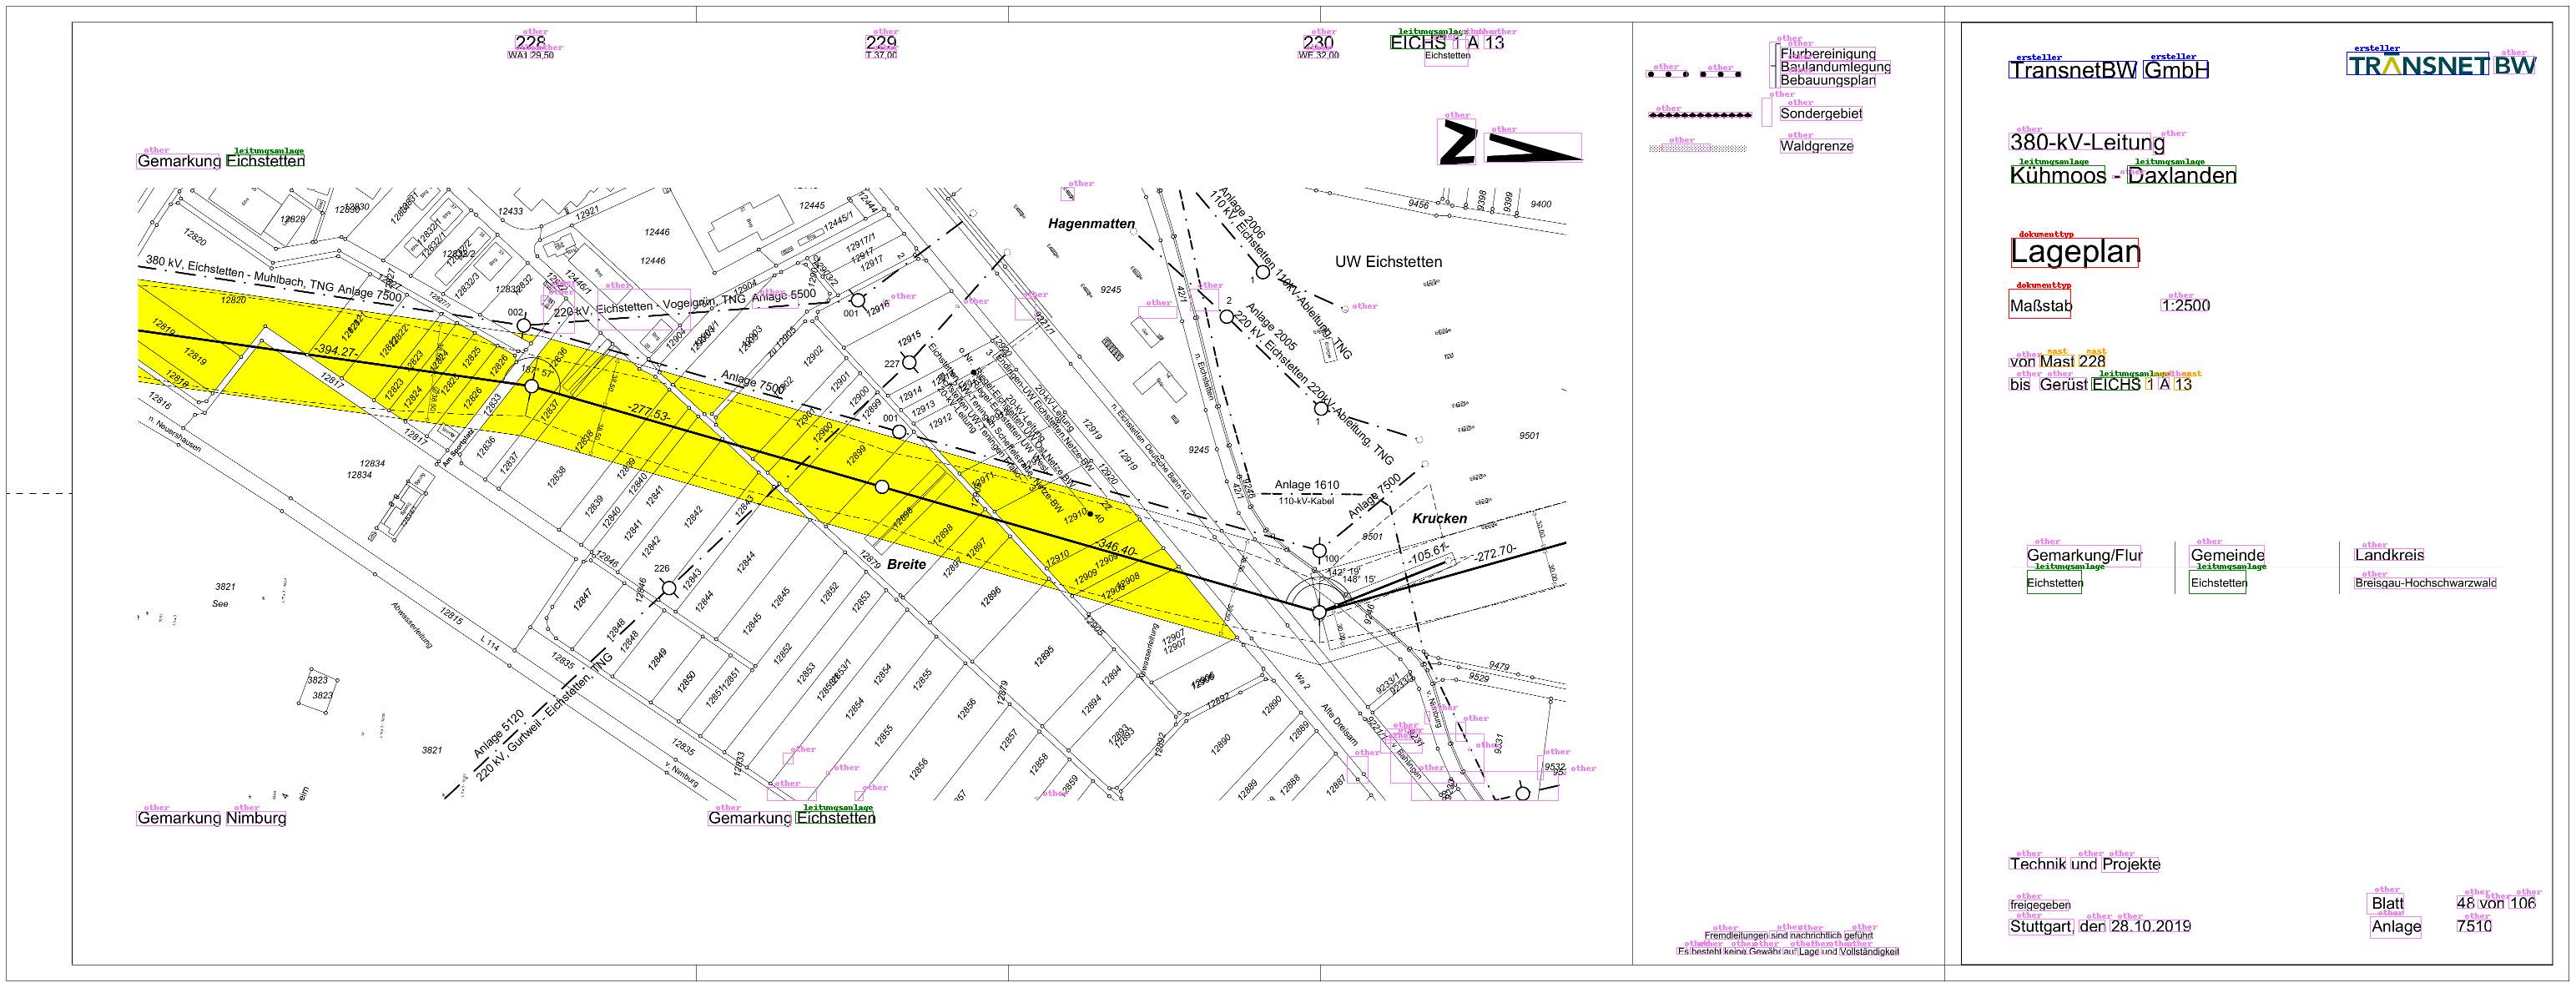

In [101]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'ersteller':'blue', 'leitungsanlage':'green', 'mast':'orange', 'dokumenttyp':'red', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [102]:
# True Inference: